In [3]:
import json


JSON_PATH = "/home/rtdip/Desktop/amos2025ws03-rtdip-timeseries-forecasting/ds_exploration/eia/data/raw/v2_petroleum_pnp_refp2_data_20251110_140454/merged.json"

with open(JSON_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

In [4]:
ds_data = data["response"]["data"]

print(f"Total records: {len(ds_data)}")

Total records: 120186


In [5]:
# create pd df

import pandas as pd

df = pd.DataFrame(ds_data)

df.head()

,period,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
0,1993-01,R3B,NA,EPJKC,Commercial Kerosene-Type Jet Fuel,YPY,Refinery Net Production,M_EPJKC_YPY_R3B_MBBL,Refining District Texas Gulf Coast Refinery Ne...,8803,MBBL
1,1993-01,R2A,NA,EPPLP,Paraffinic Lubricants,YPY,Refinery Net Production,M_EPPLP_YPY_R2A_MBBLD,Refining District Indiana-Illinois-Kentucky Re...,15,MBBL/D
2,1993-01,R3D,NA,EPPLN,Naphthenic Lubricants,YPY,Refinery Net Production,M_EPPLN_YPY_R3D_MBBL,Refining District North Louisiana-Arkansas Ref...,None,MBBL
3,1993-01,R50,PADD 5,EPJKM,Military Kerosene-Type Jet Fuel,YPY,Refinery Net Production,M_EPJKM_YPY_R50_MBBLD,West Coast (PADD 5) Refinery Net Production of...,31,MBBL/D
4,1993-01,R3A,NA,EPJKM,Military Kerosene-Type Jet Fuel,YPY,Refinery Net Production,M_EPJKM_YPY_R3A_MBBLD,Refining District Texas Inland Refinery Net Pr...,3,MBBL/D


In [5]:
df.info()
df.describe(include='all')
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120186 entries, 0 to 120185
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   period              120186 non-null  object
 1   duoarea             120186 non-null  object
 2   area-name           120186 non-null  object
 3   product             120186 non-null  object
 4   product-name        120186 non-null  object
 5   process             120186 non-null  object
 6   process-name        120186 non-null  object
 7   series              120186 non-null  object
 8   series-description  120186 non-null  object
 9   value               116668 non-null  object
 10  units               120186 non-null  object
dtypes: object(11)
memory usage: 10.1+ MB


period                  229
duoarea                  16
area-name                 7
product                  56
product-name             56
process                   1
process-name              1
series                 1575
series-description     1575
value                 13794
units                     2
dtype: int64

In [6]:
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
display(pd.concat([missing, missing_pct], axis=1, keys=['missing_count', 'missing_%']))


,missing_count,missing_%
value,3518,2.92713
duoarea,0,0.00000
period,0,0.00000
area-name,0,0.00000
product,0,0.00000
process,0,0.00000
product-name,0,0.00000
process-name,0,0.00000
series,0,0.00000
series-description,0,0.00000


In [7]:
display(df.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T)

,count,unique,top,freq
period,120186,229,2010-03,1408
duoarea,120186,16,NUS,9457
area-name,120186,7,NA,70551
product,120186,56,EPJKC,6527
product-name,120186,56,Commercial Kerosene-Type Jet Fuel,6527
process,120186,1,YPY,120186
process-name,120186,1,Refinery Net Production,120186
series,120186,1575,M_EPJKM_YPY_R50_MBBL,227
series-description,120186,1575,West Coast (PADD 5) Refinery Net Production of...,227
value,116668,13794,0,5951


In [21]:
# ensure string type and remove whitespace
df['period'] = df['period'].astype(str).str.strip()

# get the last (lexicographically largest) value
last_period = df['period'].max()

print(last_period)

2025-04


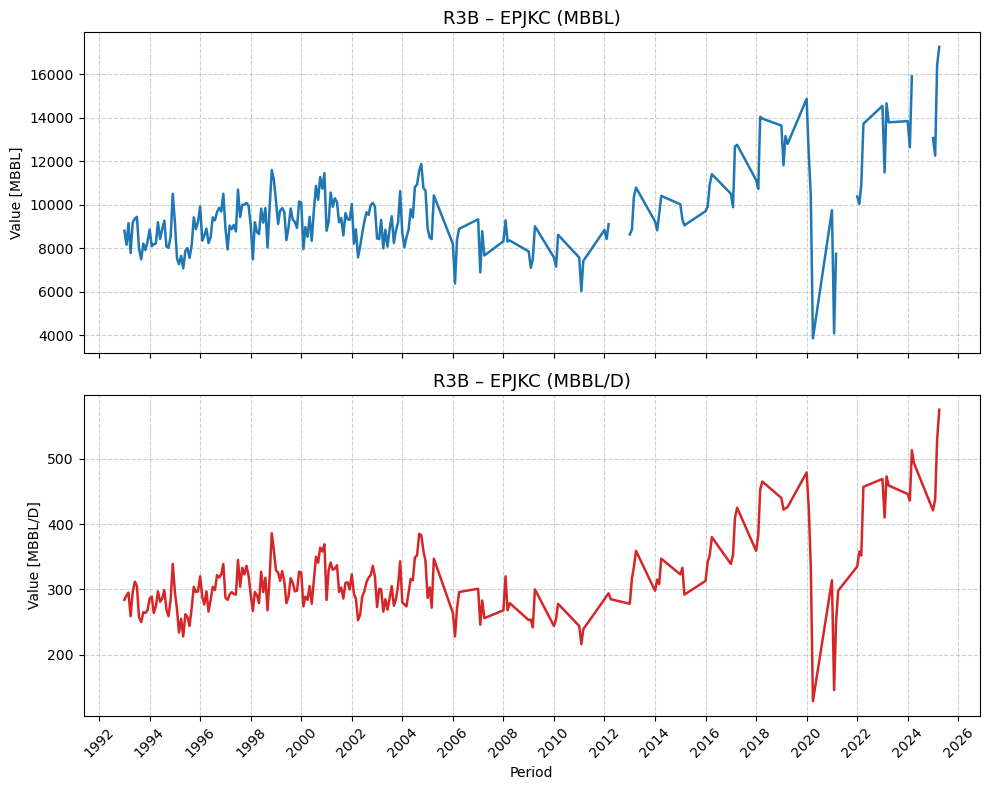

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# ensure correct datatypes
df['period'] = pd.to_datetime(df['period'], errors='coerce')
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# filter for specific refinery and product
plant_code = "R3B"
product_code = "EPJKC"

plant_df = df[
    (df['duoarea'] == plant_code) &
    (df['product'] == product_code)
].copy()

# aggregate per unit and month
agg_units = (
    plant_df.groupby(['period', 'units'], as_index=False)['value']
    .sum()
    .pivot(index='period', columns='units', values='value')
)

# create figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- MBBL ---
if 'MBBL' in agg_units.columns:
    axes[0].plot(agg_units.index, agg_units['MBBL'], color='tab:blue', linewidth=1.8)
    axes[0].set_title(f"{plant_code} – {product_code} (MBBL)", fontsize=13)
    axes[0].set_ylabel("Value [MBBL]")
    axes[0].grid(True, linestyle="--", alpha=0.6)

# --- MBBL/D ---
if 'MBBL/D' in agg_units.columns:
    axes[1].plot(agg_units.index, agg_units['MBBL/D'], color='tab:red', linewidth=1.8)
    axes[1].set_title(f"{plant_code} – {product_code} (MBBL/D)", fontsize=13)
    axes[1].set_ylabel("Value [MBBL/D]")
    axes[1].grid(True, linestyle="--", alpha=0.6)

# shared x-axis formatting
axes[-1].set_xlabel("Period")
for ax in axes:
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [6]:
df = pd.DataFrame(ds_data)

df['value'] = pd.to_numeric(df['value'], errors='coerce').fillna(0)
df['period'] = pd.to_datetime(df['period'], errors='coerce')

# --- Step 2: Filter for consistent units (e.g. only MBBL) ---
valid_units = ["MBBL"]       # or ["MBBL/D"] if you want per-day production
df = df[df['units'].isin(valid_units)]

# --- Step 3: Aggregate per month, area and product ---
monthly = (
    df.groupby(['period', 'duoarea', 'area-name', 'product'], as_index=False)['value']
      .sum()
)

# --- Step 4: Compute statistics per area ---
stats_list = []
for (area, name), subdf in monthly.groupby(['duoarea', 'area-name']):
    desc = subdf['value'].describe(
        percentiles=[0.01, 0.05, 0.25, 0.75, 0.95, 0.99]
    ).to_frame().T
    desc['duoarea'] = area
    desc['area-name'] = name
    desc['range'] = desc['max'] - desc['min']
    desc['iqr'] = desc['75%'] - desc['25%']
    stats_list.append(desc)

area_stats = pd.concat(stats_list, ignore_index=True)
area_stats = area_stats.sort_values('mean', ascending=False)

display(area_stats[['duoarea', 'area-name', 'mean', 'std', 'range', 'iqr']].head(10))


,duoarea,area-name,mean,std,range,iqr
0,NUS,U.S.,20418.393418,53409.199708,526298.0,14649.50
6,R30,PADD 3,11610.990949,29402.846986,283333.0,9280.25
8,R3B,NA,5876.758176,14608.089231,145575.0,5210.75
9,R3C,NA,5087.700290,12285.198508,116331.0,4281.50
2,R20,PADD 2,4809.382353,12379.623364,107760.0,4086.00
3,R2A,NA,3206.175731,7663.504548,69855.0,2747.00
13,R50,PADD 5,3112.783005,7386.401872,68548.0,2445.75
1,R10,PADD 1,1554.524858,4178.687076,58087.0,1202.50
15,REC,NA,1484.631422,3979.890059,55386.0,1110.75
5,R2C,NA,1358.582295,3609.504681,27799.0,707.00


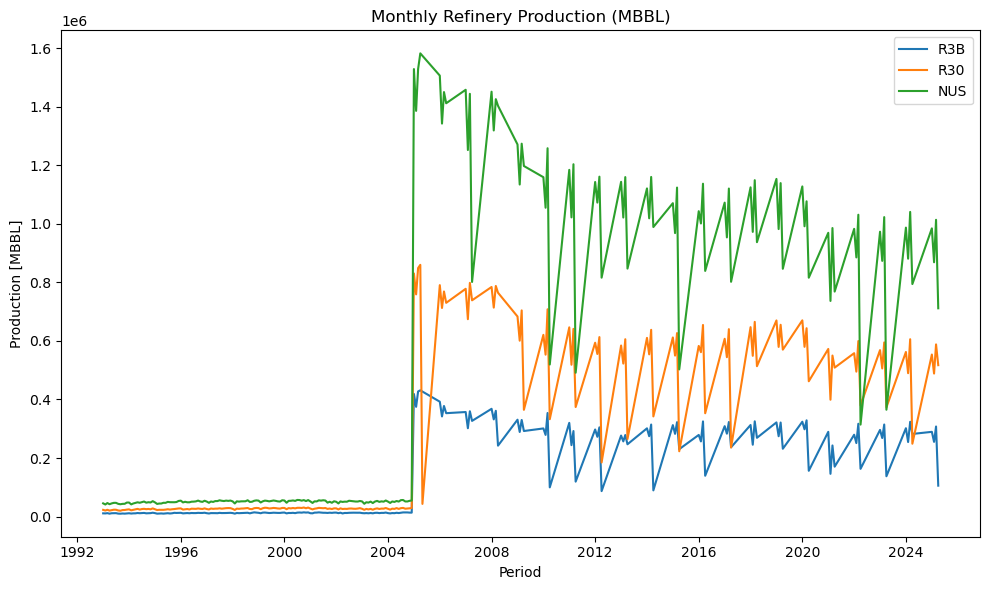

,duoarea,trend_strength,seasonal_strength,n_points
2,NUS,0.886752,0.933713,228
1,R30,0.856845,0.902187,229
0,R3B,0.856639,0.913179,228


In [ ]:
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

WINDOW = 12
results = []

plt.figure(figsize=(10, 6))
for area in ['R3B', 'R30', 'NUS']:
    subset = monthly[monthly['duoarea'] == area]
    ts = (
        subset.groupby('period')['value']
        .sum()
        .sort_index()
    )

    # --- Plot ---
    plt.plot(ts.index, ts.values, label=area)

    # --- Trend / Seasonality-Score ---
    if len(ts) >= MIN_LENGTH and ts.var() > 0:
        # Rolling-Trend
        rolling_mean = ts.rolling(window=WINDOW, min_periods=WINDOW//2).mean()
        trend_strength = np.var(rolling_mean.dropna()) / np.var(ts)

        # Seasonality
        try:
            decomp = seasonal_decompose(ts, period=WINDOW, model='additive', extrapolate_trend='freq')
            seasonal_strength = 1 - (np.var(decomp.resid.dropna()) / np.var(ts))
        except Exception:
            seasonal_strength = np.nan
    else:
        trend_strength, seasonal_strength = np.nan, np.nan

    # Speichern
    results.append({
        "duoarea": area,
        "trend_strength": trend_strength,
        "seasonal_strength": seasonal_strength,
        "n_points": len(ts)
    })

plt.title("Monthly Refinery Production (MBBL)")
plt.xlabel("Period")
plt.ylabel("Production [MBBL]")
plt.legend()
plt.tight_layout()
plt.show()

# --- Ergebnisse anzeigen ---
trend_summary = pd.DataFrame(results).sort_values("trend_strength", ascending=False)
display(trend_summary)



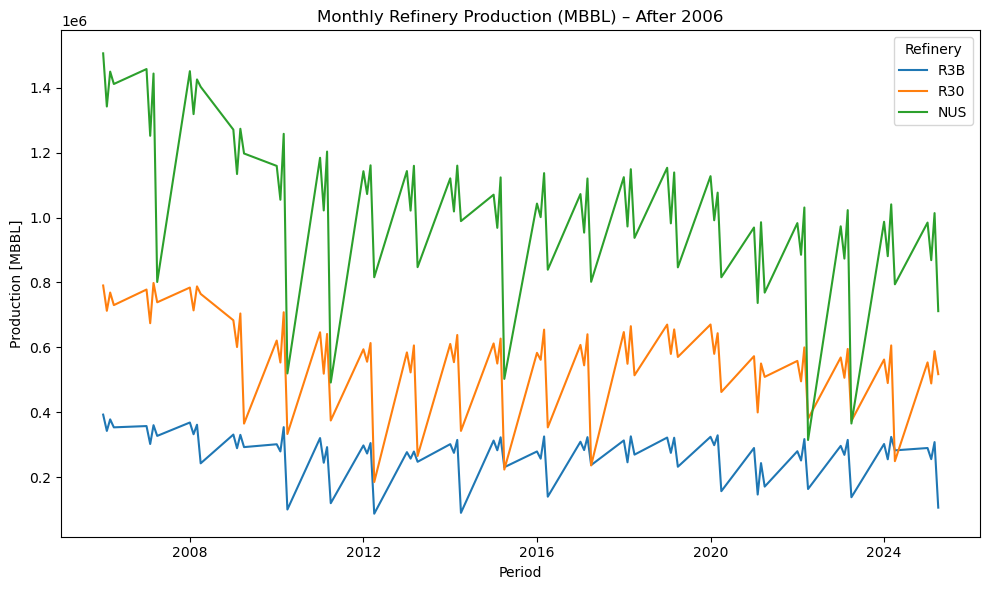

,duoarea,trend_strength,seasonal_strength,n_points
2,NUS,0.410395,0.796275,80
1,R30,0.342718,0.762639,80
0,R3B,0.224469,0.765235,80


In [ ]:
WINDOW = 12

results = []

plt.figure(figsize=(10, 6))
for area in ['R3B', 'R30', 'NUS']:
    subset = monthly[monthly['duoarea'] == area].copy()
    
    # --- Filter: data before 2006 --> interferes with seasonality detection ---
    subset = subset[subset['period'] >= '2006-01-01']

    # --- Zeitreihe aggregieren ---
    ts = (
        subset.groupby('period')['value']
        .sum()
        .sort_index()
    )

    # --- Plot ---
    plt.plot(ts.index, ts.values, label=area)

    # --- Trend / Seasonality-Score ---
    if len(ts) >= MIN_LENGTH and ts.var() > 0:
        # Rolling-Trend
        rolling_mean = ts.rolling(window=WINDOW, min_periods=WINDOW//2).mean()
        trend_strength = np.var(rolling_mean.dropna()) / np.var(ts)

        # Seasonality
        try:
            decomp = seasonal_decompose(ts, period=WINDOW, model='additive', extrapolate_trend='freq')
            seasonal_strength = 1 - (np.var(decomp.resid.dropna()) / np.var(ts))
        except Exception:
            seasonal_strength = np.nan
    else:
        trend_strength, seasonal_strength = np.nan, np.nan

    results.append({
        "duoarea": area,
        "trend_strength": trend_strength,
        "seasonal_strength": seasonal_strength,
        "n_points": len(ts)
    })

plt.title("Monthly Refinery Production (MBBL) - After 2006")
plt.xlabel("Period")
plt.ylabel("Production [MBBL]")
plt.legend(title="Refinery")
plt.tight_layout()
plt.show()

# --- Show results ---
trend_summary = pd.DataFrame(results).sort_values("trend_strength", ascending=False)
display(trend_summary)
